In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# 1. Read and Display Images from Files

In [2]:
path_to_image = '/kaggle/input/intel-image-classification/seg_train/seg_train/buildings/0.jpg'

There are 3 libraries that can be used to read and display images: matplotlib, Pillow, and opencv

## Matplotlib

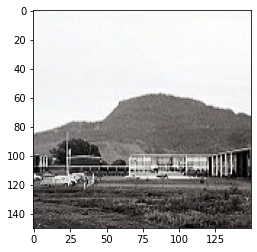

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# reads the image
img = mpimg.imread(path_to_image)

# plots the image
imgplot = plt.imshow(img)

## Pillow

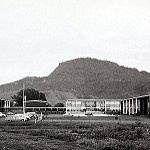

In [4]:
from PIL import Image
image = Image.open(path_to_image)

# supposedly, image.show() should work, but it doesn't work for me
# image.show()

image

## OpenCV

Note that it looks weird because open cv reads BGR instead of RGB like the other methods

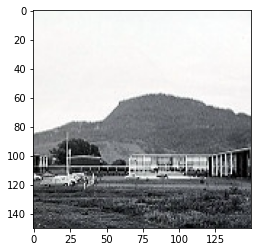

In [5]:
import cv2

# gets image array
img = cv2.imread(path_to_image)

# Uncomment the line below to convert to normal colors
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Need to use matplotlib to show
plt.imshow(img)

# 2. Read All Images From a Directory*

There are two ways to do this: os.listdir() and using glob. 

The glob module is preferred if you want to define a wildcard and get all the files matching that wildcard, whereas os.lisdir simply returns all files in the directory.

## os.listdir

os.listdir says "go to this directory, and return a list of all the files in it"

In [6]:
PATH = '/kaggle/input/intel-image-classification/'

# using os.listdir
# pass the directory to read as an argument
train_buildings_images = os.listdir(PATH + 'seg_train/seg_train/buildings')
train_buildings_images[0:3]

# Returns ['1846.jpg', '11670.jpg', '10278.jpg']

['230.jpg', '1220.jpg', '17272.jpg']

## glob

glob says "give me the complete path to all files that match this form"

In [7]:
# using glob
import glob

# Gets all files that end in '.jpg', in case there are others
# Pass directory as an argument, using * as a wildcard for any number of characters
train_buildings_images = glob.glob(PATH + 'seg_train/seg_train/buildings/' + '*.jpg')
train_buildings_images[0:3]

# Returns ['/kaggle/input/intel-image-classification/seg_train/seg_train/buildings/1846.jpg',
 #'/kaggle/input/intel-image-classification/seg_train/seg_train/buildings/11670.jpg',
 #'/kaggle/input/intel-image-classification/seg_train/seg_train/buildings/10278.jpg']

['/kaggle/input/intel-image-classification/seg_train/seg_train/buildings/230.jpg',
 '/kaggle/input/intel-image-classification/seg_train/seg_train/buildings/1220.jpg',
 '/kaggle/input/intel-image-classification/seg_train/seg_train/buildings/17272.jpg']

# 3. Images as Arrays

At their heart, images are just pixel arrays.

For color images, the dimensions will be [x dimension] * [y dimension] * [3] (for the 3 channels: Red, Green, Blue)

For black and white images, the dimensions will just be [x dimension] * [y dimension]

## matplotlib

matplotlib reads images as arrays

In [8]:
# Matplotlib
img = mpimg.imread(train_buildings_images[0])
print(len(img))
print(len(img[0]))
print(len(img[0][0]))

150
150
3


## Pillow

pillow reads images as 'Image' objects. To see the array elements, the objects will need to be cast as numpy arrays.

In [9]:
# Pillow
image = Image.open(train_buildings_images[0])

# cast as numpy array
img_array = np.asarray(image)

print(len(img_array))
print(len(img_array[0]))
print(len(img_array[0][0]))

150
150
3


## OpenCV

OpenCV also reads images directly as arrays

In [10]:
# Open CV

img = cv2.imread(train_buildings_images[0])
print(len(img))
print(len(img[0]))
print(len(img[0][0]))

150
150
3


# 4. Create torch dataloaders for a neural network

PyTorch neural networks are trained on DataLoaders. 

The typical flow is 
numpy arrays -> torch tensors -> torch datasets -> torch datasets

For images, I think it's easiest to create a custom dataset by overriding the torch dataset class, and read in the images at that time.

Then we can split into training and validation set, and convert to torch datasets.

## Custom torch Datasets

Custom pytorch datasets have an init, getitem, and len methods

In [11]:
# This is specific to this notebook, and not needed in general

label_dict = {
    "buildings":0,
    "forest":1,
    "glacier":2,
    "mountain":3,
    "sea":4,
    "street":5
}

In [12]:
# Libraries needed to make dataset

import torch
from torchvision import transforms

Note a few things about the custom dataset:

1. Use transforms to make normalize images and make them the same size.

2. Read images with pillow, since torch.transform works on PIL Image objects

3. The transforms.ToTensor() method changes the dimensions from (H x W x C) to (C x H x W) 

In [13]:
class custom_dataset(torch.utils.data.Dataset):
    
    def __init__(self):
        
        # Use glob to get a list of all the image files
        self.filenames = glob.glob('/kaggle/input/intel-image-classification/seg_train/seg_train/*/*.jpg')
    
        # Transformations. All we do is make sure that all images
        # are the same size, convert them to tensors, and normalize them to have mean 0.5
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5, 0.5)
        ])
        
        # The length of the dataset is the number of images
        self.len = len(self.filenames)
        
        # An item is the image and its label
    def __getitem__(self, index):
        
        # torch.transform wants a PIL image object
        image = Image.open(self.filenames[index])
        label = label_dict[self.filenames[index].split('/kaggle/input/intel-image-classification/seg_train/seg_train/')[1].split('/')[0]]
        return self.transform(image), label
    
        # Length is already defined
    def __len__(self):
        return self.len

In [14]:
# Instantiate
img_dataset = custom_dataset()

## Break into a training set and a validation set. Convert to data loaders

In [15]:
train_size = 0.8 # use 80% for training

train_len = int(train_size*img_dataset.len)
valid_len = img_dataset.len - train_len

# training and validation datasets
train, valid = torch.utils.data.random_split(img_dataset, lengths=[train_len, valid_len])

In [16]:
# Library for making data loaders
from torch.utils.data import DataLoader

# Choose batch size before making data loaders
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=True)

## View an image and a label from the data loader

In [17]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

tensor(2)


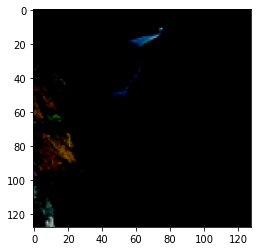

In [18]:
# Need to transform because torch.Transform changed dimension order
plt.imshow(np.transpose(images[0], (1, 2, 0)))
print(labels[0])

# 5. Convolutional Neural Networks

In [19]:
# Library needed to make neural network

import torch.nn as nn

## Define model

This is where you get to actually define the structure of your neural network.

At its core, the structure of a CNN will be some number of the following:

1. A convolution layer
    - scans the whole image
    - increases the number of channels, each of which can be thought of as corresponding to a "feature"
    
2. A pooling layer
     - Scales down the amount of information the convolutional layer generated
     
3. An activation function
    - This makes the model easier to train
    
Followed by...

4. Flattening

5. A fully connected layer corresponding to the desired output size

Typically, dropout layers are not used in CNN's.

There's some mathe needed to determine the size of the linear layer, though if you get it wrong, and error will show up and tell you what size you should use.

In this example, the flow goes like this:

start: 3 channels 128 x 128 image

convolution 1: 16 channels of 126 x 126 
     
pooling 1: 16 channels of 63 x 63

convolution 2: 32 channels of 61 x 61
pooling 2: 32 channels of 30 x 30

convolution 3: 64 channels of 28 x 28
pooling 3: 64 channels of 14 x 14

linear: flatten to 64 x 14 x 14 = 12544

In [20]:
# In this example, I used three convolution layers

class CNNModel(nn.Module):
    
    # Do this for ANY pytorch neural net
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
         
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
                
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 0)
        self.relu3 = nn.ReLU()
        
        # Max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
                
        # This actually went down when I added another convolution layer??
        self.fc1 = nn.Linear(12544, 6)
        
    def forward(self, x):
        
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)
        
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        
        return out

## Choose hyperparamters

This is really where the bulk of time is spend - tuning these to get the most accurate model possible.

For classification problems, cross entroy loss is typically used.

The number of epochs can vary widely, as long as you don't overfit. In this code, I found 50 epochs to work best.

It seems like a learning rate of 0.001 usually works well, but I often see as small as 1e-5.

In [29]:
model = CNNModel()
model = model.cuda()

error = nn.CrossEntropyLoss()
n_epochs = 1
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
from torch.autograd import Variable

## Training the Model

This code is standard for training any pytorch model. Note that validation is done at each epoch.

In [33]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = images.view(-1, 3, 128, 128) # Make the images of size [batch size * channels * x pixels * y pixels]
        train = train.cuda()
        labels = labels.cuda()
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propogation
        output = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(output, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
       
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in valid_loader:

        images = images.cuda()
        labels = labels.cuda()

        test = Variable(images.view(-1, 3, 128, 128))

        # Forward propagation
        outputs = model(test)

        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]

        # Total number of labels
        total += len(labels)

        correct += (predicted == labels).sum()

    accuracy = 100 * correct / float(total)

    # store loss and iteration
    loss_list.append(loss.data)
    iteration_list.append(count)
    accuracy_list.append(accuracy)

    # Print Loss
    print('Validation Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

KeyboardInterrupt: 